In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json
from pandas.io.json import json_normalize

%matplotlib inline

init_notebook_mode(connected=True)

In [2]:
def str_to_list(x):
    return eval(x) if x and x != '#N/A' else []

list_cols = [
    'genres',
    'belongs_to_collection',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'Keywords',
    'cast',
    'crew'
]


## set io_params to unfold the JSON-like string to lists
io_params = {
    'index_col': 'id',
    'converters': {col: str_to_list for col in list_cols}
}

# We can read the train and the test in one go using the concat function
# data = pd.read_csv('../data/train.csv', **io_params)
data = pd.concat(
    objs=(
        pd.read_csv('/Users/shenghaoxu/Desktop/DS_Projects/kaggle_box_office/box_office_pred/data/train.csv', **io_params).assign(is_train=True),
        pd.read_csv('/Users/shenghaoxu/Desktop/DS_Projects/kaggle_box_office/box_office_pred/data/test.csv', **io_params).assign(is_train=False)
    ),
    sort=False
)


In [3]:
train_eda_data = data[data['is_train'] == True] 

## EDA and Feature Engineering

In [4]:
## budget:
budget_plot_data = [go.Scatter(x=train_eda_data['budget'], y=train_eda_data['revenue'], mode='markers')]
layout = go.Layout(
    xaxis=dict(
        range=[0, 1e8]
    ),
    yaxis=dict(
        range=[0, 1e9]
    )
)
iplot(go.Figure(data = budget_plot_data))

['Mystery', 'Romance', 'History', 'Family', 'Fantasy', 'Horror', 'Crime', 'Drama', 'Science Fiction', 'Animation', 'Music', 'Adventure', 'Foreign', 'Action', 'TV Movie', 'Comedy', 'Documentary', 'War', 'Thriller', 'Western']
Mystery
Romance
History
Family
Fantasy
Horror
Crime
Drama
Science Fiction
Animation
Music
Adventure
Foreign
Action
TV Movie
Comedy
Documentary
War
Thriller
Western
Mystery
Romance
History
Family
Fantasy
Horror
Crime
Drama
Science Fiction
Animation
Music
Adventure
Foreign
Action
TV Movie
Comedy
Documentary
War
Thriller
Western


Text(0,0.5,'Average Revenues')

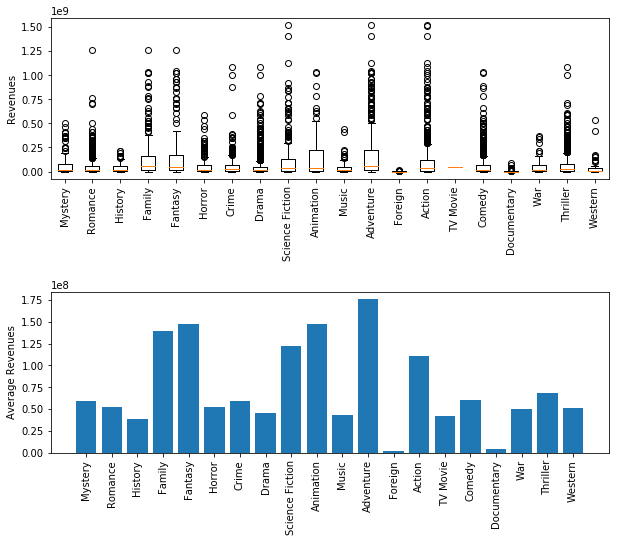

In [5]:
## genres: one hot encoding
def check_values(column, key, value):
    """
    input: 
    output: a vector of True/False
    """
    results = []
    for list_of_dict in column:
        value_found = False
        for item in list_of_dict:
            if item[key] == value:
                value_found = True
        results.append(value_found)
    return results
    
def get_freqs(series, attribute):
    freq_dict = {}
    for values_list in series:
        for values_dict in values_list:
            if values_dict[attribute] not in freq_dict:
                freq_dict[values_dict[attribute]] = 1
            else:
                freq_dict[values_dict[attribute]] += 1
    return freq_dict

genre_freq = get_freqs(data['genres'], 'name')
unique_genres = genre_freq.keys()

print(unique_genres)

## One-Hot Encoding:
for genre_name in unique_genres:
    data[genre_name] = np.where(check_values(data['genres'], 'name', genre_name), 1, 0)

data_to_plot = []
for genre_name in unique_genres:
    print(genre_name)
    data_to_plot.append(data[data[genre_name] == 1 & data['is_train']]['revenue'].dropna().values)

fig = plt.figure(1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Create an axes instance
ax = fig.add_subplot(211)

# Create the boxplot
ax.boxplot(data_to_plot)
ax.set_xticklabels(unique_genres)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Revenues')

    
averages = []
for genre_name in unique_genres:
    print(genre_name)
    averages.append(data[data[genre_name] == 1 & data['is_train']]['revenue'].dropna().values.mean())

genre_barplot = fig.add_subplot(212)
genre_barplot.bar(unique_genres, averages)
genre_barplot.tick_params(axis='x', labelrotation=90)
genre_barplot.set_ylabel('Average Revenues')


In [6]:
# Languages: one-hot encoding

language_freq = get_freqs(data['spoken_languages'], 'iso_639_1')
# sorted(language_freq.items(), key=operator.itemgetter(1))
unique_languages = language_freq.keys()


sorted_languages = sorted([(value,key) for (key,value) in language_freq.items()], reverse=True)
top_20_languages = [i[1] for i in sorted_languages[0:20]]
print(top_20_languages)


## One-Hot Encoding:
for language in top_20_languages:
    data[language] = np.where(check_values(data['spoken_languages'], 'iso_639_1', language), 1, 0)

['en', 'fr', 'es', 'de', 'ru', 'it', 'ja', 'zh', 'hi', 'ar', 'pt', 'cn', 'ko', 'pl', 'la', 'hu', 'cs', 'th', 'ta', 'sv']


Text(0,0.5,'Average Revenues')

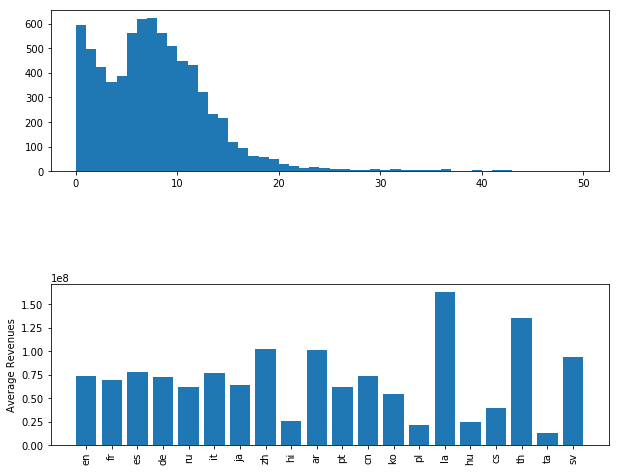

In [7]:
# Popularity and spoken_languages:

# plt.scatter(x=data[data['is_train']]['popularity'], y = data[data['is_train']]['revenue'])
popularity_fig = plt.figure(1, figsize=(10, 8))
popularity_fig.subplots_adjust(hspace=0.7, wspace=0.4)

popularity_hist = popularity_fig.add_subplot(211)

popularity_hist.hist(x=data[data['is_train'] & data['popularity'] < 50]['popularity'], bins=50, range=[0, 50])

## TODO: Popularity vs. Revenue

# average revenues for top 20 languages:
revenue_averages_by_popularity = []
for language_name in top_20_languages:
    revenue = data[data[language_name] == 1 & data['is_train']]['revenue'].dropna().values.mean()
#     print(revenue)
    revenue_averages_by_popularity.append(revenue)
    
language_barplot = popularity_fig.add_subplot(212)
language_barplot.bar(top_20_languages, revenue_averages_by_popularity)
language_barplot.tick_params(axis='x', labelrotation=90)
language_barplot.set_ylabel('Average Revenues')

[120334673.54950495, 109670828.09574468, 124783063.90062112, 113961915.66666667, 120284417.32967032, 68721455.66666667, 145159176.37333333, 76546547.3015873, 303777082.5483871, 75911345.01639344, 44320248.60869565, 78391981.6981132, 111337606.1875, 62731346.13636363, 51829712.675, 139645381.44444445, 105011750.41935484, 187110073.44444445, 47225870.862068966, 72128865.75, 230780010.26086956, 50162012.21428572, 107563052.83333333, 168699729.36666667, 121310733.5, 71010524.26086956, 30096600.541666668, 20106736.533333335, 51769026.583333336, 103727195.72, 24884434.222222224, 122833995.5625, 105927439.6111111, 26829718.19047619, 38399166.35714286, 61720925.047619045, 82169277.4, 74317436.07692307, 72246640.5, 59679290.28571428, 357564820.3684211, 84879718.4375, 14378118.666666666, 182865902.45454547, 291025417.625, 106764133.1764706, 45582427.333333336, 105859345.0909091, 82202072.0, 35947946.684210524]


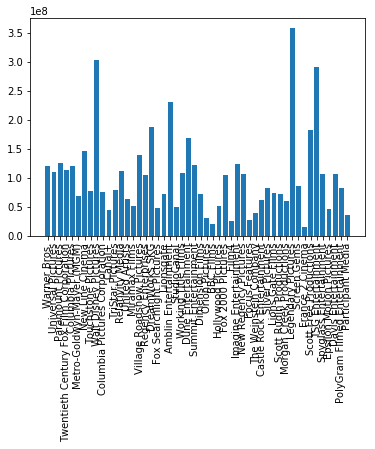

In [8]:
# Production companies:
company_freq = get_freqs(data['production_companies'], 'name')
# print(company_freq)

sorted_companies = sorted([(value, key) for (key, value) in company_freq.items()], reverse=True)
top_companies = [i[1] for i in sorted_companies[0:50]]
# print(top_10_companies)

# One-Hot Encoding:
for company in top_companies:
    data[company] = np.where(check_values(data['production_companies'], 'name', company), 1, 0)

average_revenues_by_company = []
for company in top_companies:
    revenue = data[data[company] == 1 & data['is_train']]['revenue'].dropna().values.mean()
    average_revenues_by_company.append(revenue)

print(average_revenues_by_company)

plt.bar(top_companies, average_revenues_by_company)
plt.tick_params(axis='x', labelrotation=90)


month_released
1     3.070678e+07
2     5.778889e+07
3     7.224145e+07
4     5.831416e+07
5     9.048772e+07
6     1.278864e+08
7     9.404021e+07
8     4.151070e+07
9     3.582428e+07
10    4.204264e+07
11    7.702461e+07
12    9.646238e+07
Name: revenue, dtype: float64


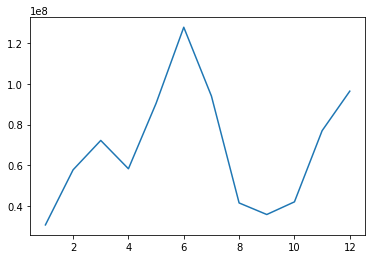

In [9]:
# release_data: group by months

from dateutil import parser

## there is one instance in the dataset that has release_date == NaN
data = data.drop(data[data['release_date'].isnull()].index)

parsed_months = []
for i in range(len(data['release_date'].values)):
    parsed_months.append(parser.parse(data['release_date'].values[i]).month)

data['month_released'] = pd.Series(parsed_months, index = data.index)

revenue_by_month = data.groupby('month_released')['revenue'].mean()
print(revenue_by_month)

plt.plot(revenue_by_month.index, revenue_by_month.values)

# 

##### It can be seen that average revenues are highest between 5-7, 11-12

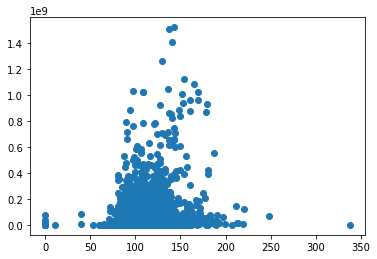

In [10]:
## Runtime:
data['runtime']
plt.scatter(data['runtime'], data['revenue'])


##### Movies run for 90 - 130 mins are most profitable. 

In [11]:
# Cast:
pd.set_option('display.max_columns', None)
data.head()
# data['cast'].head()[1]
data['crew'].head()[1]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a36

In [12]:
data.head()

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,is_train,Mystery,Romance,History,Family,Fantasy,Horror,Crime,Drama,Science Fiction,Animation,Music,Adventure,Foreign,Action,TV Movie,Comedy,Documentary,War,Thriller,Western,en,fr,es,de,ru,it,ja,zh,hi,ar,pt,cn,ko,pl,la,hu,cs,th,ta,sv,Warner Bros.,Universal Pictures,Paramount Pictures,Twentieth Century Fox Film Corporation,Columbia Pictures,Metro-Goldwyn-Mayer (MGM),New Line Cinema,Touchstone Pictures,Walt Disney Pictures,Columbia Pictures Corporation,Canal+,TriStar Pictures,Relativity Media,United Artists,Miramax Films,Village Roadshow Pictures,Regency Enterprises,DreamWorks SKG,Fox Searchlight Pictures,Lionsgate,Amblin Entertainment,StudioCanal,Working Title Films,Dune Entertainment,Summit Entertainment,Dimension Films,Orion Pictures,BBC Films,Hollywood Pictures,Fox 2000 Pictures,Film4,Imagine Entertainment,New Regency Pictures,Focus Features,The Weinstein Company,Castle Rock Entertainment,Silver Pictures,Lions Gate Films,Scott Rudin Productions,Morgan Creek Productions,Legendary Pictures,Screen Gems,France 2 Cinéma,Scott Free Productions,TSG Entertainment,Spyglass Entertainment,Epsilon Motion Pictures,Davis Entertainment,PolyGram Filmed Entertainment,Participant Media,month_released
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,[{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...,14000000,"[{u'id': 35, u'name': u'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{u'name': u'Paramount Pictures', u'id': 4}, {...","[{u'iso_3166_1': u'US', u'name': u'United Stat...",2/20/15,93.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{u'id': 4379, u'name': u'time travel'}, {u'id...","[{u'credit_id': u'52fe4ee7c3a36847f82afae7', u...","[{u'name': u'Kelly Cantley', u'gender': 0, u'd...",12314651.0,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,[{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...,40000000,"[{u'id': 35, u'name': u'Comedy'}, {u'id': 18, ...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{u'name': u'Walt Disney Pictures', u'id': 2}]","[{u'iso_3166_1': u'US', u'name': u'United Stat...",8/6/04,113.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{u'id': 2505, u'name': u'coronation'}, {u'id'...","[{u'credit_id': u'52fe43fe9251416c7502561f', u...","[{u'name': u'Garry Marshall', u'gender': 2, u'...",95149435.0,True,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,[],3300000,"[{u'id': 18, u'name': u'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{u'name': u'Bold Films', u'id': 2266}, {u'nam...","[{u'iso_3166_1': u'US', u'name': u'United Stat...",10/10/14,105.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{u'id': 1416, u'name': u'jazz'}, {u'id': 1523...","[{u'credit_id': u'52fe4ef7c3a36847f82b3fc3', u...","[{u'name': u'Terri Taylor', u'gender': 1, u'de...",13092000.0,True,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [58]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = data[data['status'] == 'Released']
dropped_variables = ['belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'is_train', 'revenue']
data = data.drop(data[data['runtime'].isnull()].index)

X = data[data['is_train']].drop(dropped_variables, axis = 1)
y = data[data['is_train']]['revenue']


# scale
X['budget'] = preprocessing.scale(X['budget'])
X['popularity'] = preprocessing.scale(X['popularity'])
X['runtime'] = preprocessing.scale(X['runtime'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
test = data[data['is_train'] == False].drop(dropped_variables, axis = 1)
                     

In [59]:
# # X = X.drop(X[X['runtime'].isnull()].index)
# # X.isnull().values.any()
X_train.isnull().values.any()

False

In [70]:
# Linear regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import math
# import lightgbm as lgb

In [16]:
n_folds = 10

def accuracy_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    score = cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_log_error', cv = kf)
    return(score)

### Linear regression

In [78]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
error = mean_squared_error(y_val, y_pred)
(y_val

id
2373    129540499.0
1091     36869414.0
322     183018522.0
1040        45250.0
1508     16017403.0
179     125212904.0
496      11838218.0
472     459270619.0
2541      3623330.0
290      11373501.0
1776      9114264.0
1276     25000000.0
1810    163794509.0
1051     29762011.0
774         48752.0
2924     16209459.0
1726    124914842.0
458        340147.0
2888     36642838.0
145      11000000.0
1615     40846082.0
403          8251.0
1815      4635143.0
1229     16974459.0
45       47175038.0
1044       331000.0
197        136203.0
814      21000000.0
2378     92991835.0
52       25333333.0
           ...     
158        447784.0
1908    112462508.0
1614     38955598.0
679       1296937.0
1676      7237794.0
2298    297138014.0
239     505000000.0
1836      7282851.0
1564        30471.0
1971      7500000.0
101       9229401.0
316     113020255.0
2503     28215918.0
1661     13275000.0
761      24793509.0
869     108539911.0
262      87528173.0
789       2334228.0
2476    373552094

In [79]:
y_pred

array([ 6.69479992e+07,  4.14708356e+07,  2.14300429e+08,  9.23139465e+06,
       -4.56224064e+06,  4.06584704e+07,  8.88788894e+07,  1.91368490e+08,
        3.76925736e+06,  1.10979321e+08,  2.88246528e+07,  9.30309738e+06,
        3.73538749e+08,  1.95811992e+08, -1.49814297e+07,  2.04294794e+07,
        1.16478274e+08, -2.55716274e+07, -2.64779704e+07,  2.65458521e+07,
        6.42630096e+07, -9.03721647e+06,  2.48377477e+07,  3.01876267e+07,
        4.67795843e+07, -1.79786016e+07,  9.86295807e+06,  1.45514259e+07,
        4.70227994e+07,  9.57462134e+07, -1.51008509e+07, -1.16937989e+07,
        1.30430139e+08,  3.44049807e+07,  2.91180682e+07,  3.34551711e+07,
        1.89889807e+07,  5.46581350e+07,  3.81761087e+07,  5.12533302e+07,
        1.37717384e+08,  9.00495649e+07,  9.31759890e+05,  1.50279672e+08,
       -3.73171419e+07, -2.74824838e+07, -2.23177995e+06,  3.00694622e+08,
        2.95032496e+07,  5.33398971e+08,  6.94459658e+07,  1.94935306e+07,
        1.49168174e+08,  

### Ridge Regression

In [18]:
Ridge = make_pipeline(RobustScaler(), RidgeClassifier(random_state=1))


### Random Forest

In [19]:
RandomForest = RandomForestClassifier(random_state=1)


### XGBoost

In [20]:
model_xgb = xgb.XGBClassifier()


## Base Model Scores:

In [21]:
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose = False) :
    
    params = {'objective': 'reg:linear', 
              'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'seed': random_seed, 
              'silent': True,
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}

In [30]:
random_seed = 2019
result = xgb_model(X_train, y_train, X_val, y_val, test)
# fold_val_pred.append(result['val']*0.2)
# fold_test_pred.append(result['test']*0.2)
# fold_err.append(result['error'])
# print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')

NameError: name 'fold_val_pred' is not defined

In [29]:
result

{'error': 69781144.0,
 'importance': [323,
  291,
  426,
  149,
  53,
  528,
  100,
  143,
  388,
  9,
  202,
  58,
  1790,
  137,
  6,
  6,
  130,
  143,
  58,
  124,
  141,
  26,
  318,
  10,
  210,
  110,
  212,
  66,
  506,
  212,
  1,
  109,
  29,
  198,
  36,
  3608,
  64,
  93,
  27,
  115,
  210,
  5,
  2,
  127,
  108,
  119,
  24,
  8,
  41,
  4,
  31,
  11,
  90,
  82,
  7,
  50,
  13,
  361,
  6,
  193,
  308,
  85,
  5626,
  159,
  322,
  229,
  2,
  378,
  91,
  1,
  22,
  11,
  86,
  75,
  10,
  60,
  63,
  132,
  472,
  95,
  246,
  69,
  155,
  80,
  28,
  7,
  1,
  152,
  6113,
  17,
  15,
  284,
  89,
  115],
 'test': array([3.4091722e+08, 6.7004390e+08, 2.6693790e+08, ..., 6.7336781e+08,
        8.4699424e+08, 6.5431654e+08], dtype=float32),
 'val': array([1.55349180e+07, 2.88192256e+08, 2.29507520e+07, 2.47715240e+07,
        7.94372720e+07, 1.38306608e+08, 9.92083400e+06, 1.02566280e+08,
        9.50219440e+07, 1.51832540e+07, 6.60341160e+07, 1.45770620e+07,
     